# Dataset Introduction - the Project Knowledge Graph

Ruijie Wang, Pascal Severin Andermatt, Rosni Vasu | 25-09-2023  
Matthias Baumgartner, Luca Rossetto, Cristina Sarasua | Dataset Construction

## 1. Overview

* The knowledge graph is
    * mainly about **movies**,
    * derived from **[Wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page)**,
    * **directed** and **connected**.


* Entities (movies, people, etc.)
    * common properties 
        * **labels** (rdfs:label)
        * **types** (wd:P31)
        * **descriptions** (schema:description)
    * namespace:
        * **wikidata_entity**(http://www.wikidata.org/entity/);
    
    
* Predicates
    * common properties
        * **labels** (rdfs:label)
        * **descriptions** (schema:description)
    * namespaces: 
        * **wikidata_property**(http://www.wikidata.org/prop/direct/)
        * **schema.org**(http://schema.org/)
        * **ddis.ch**(http://ddis.ch/atai/)
        * **rdfs**(http://www.w3.org/2000/01/rdf-schema#)
    
    
* Literal types in the graph (for some entities):
    * entity/predicate labels
    * descriptions
    * [IMDb](https://www.imdb.com/) ratings
    * box office values
    * publication dates
    * WikiCommons image URLs
    * user-defined tags
    
    
* Linked external datasets (for some entities):
    * movie plot descriptions from [MPST](https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags) and [OMDb](http://www.omdbapi.com/),
    * textual user reviews from [LMRD](https://ai.stanford.edu/~amaas/data/sentiment/),
    * images of movies (e.g., posters) and people (e.g., still images) from [MovieNet](http://movienet.site/);
    
    
**The dataset is published at https://files.ifi.uzh.ch/ddis/teaching/2023/ATAI/dataset/**

## 2. Data Analysis


### 2.1 Load the data

In [1]:
!pip install rdflib
!pip install networkx
!pip install pandas
!pip install plotly


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from rdflib.namespace import Namespace, RDF, RDFS, XSD
from rdflib.term import URIRef, Literal
import csv
import json
import networkx as nx
import pandas as pd
import rdflib
from collections import defaultdict, Counter
import locale
_ = locale.setlocale(locale.LC_ALL, '')
from _plotly_future_ import v4_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = 'jupyterlab+svg'

In [3]:
graph = rdflib.Graph()
graph.parse('DataSet/ddis-movie-graph.nt/14_graph.nt', format='turtle')

<Graph identifier=N3807ff3485b945e18d9d6bc98484f28e (<class 'rdflib.graph.Graph'>)>

### 2.2 Graph Statistics

In [4]:
# prefixes used in the graph
WD = Namespace('http://www.wikidata.org/entity/')
WDT = Namespace('http://www.wikidata.org/prop/direct/')
SCHEMA = Namespace('http://schema.org/')
DDIS = Namespace('http://ddis.ch/atai/')

In [9]:
entities = set(graph.subjects()) | {s for s in graph.objects() if isinstance(s, URIRef)} #Nodes
predicates = set(graph.predicates()) #Relations
literals = {s for s in graph.objects() if isinstance(s, Literal)} #Non URI values like string
with_type = set(graph.subjects(WDT['P31'], None)) #Name space'i WD/31 olan subjectleri getirir
with_super = set(graph.subjects(WDT['P279'], None))
types = set(graph.objects(None, WDT['P31']))
supers = set(graph.objects(None, WDT['P279']))
with_label = set(graph.subjects(RDFS.label, None))

n_ents = len(entities)
n_rels = len(predicates)
n_lits = len(literals)
t_tot = len(graph)
t_ent = len([1 for s,p,o in graph.triples((None, None, None)) if isinstance(o, URIRef)])
t_lit = t_tot - t_ent
n_notype = len(entities - with_type - with_super)
n_notype_flt = len(entities - with_type - with_super - types - supers)

pd.DataFrame([
    ('number of entities', f'{n_ents:n}'),
    ('number of literals', f'{n_lits:n}'),
    ('number of predicates', f'{n_rels:n}'),
    ('number of triples', f'{t_tot:n}'),
    ('number of ent-ent triples', f'{t_ent:n}'),
    ('number of ent-lit triples', f'{t_lit:n}'),
    ('number of entities w/o label', f'{len(entities - with_label):n}'),
    ('number of predicates w/o label', f'{len(predicates - with_label):n}'),
    ('number of entities w/o type', f'{n_notype:n}'),
    ('number of instances w/o type', f'{n_notype_flt:n}'),
    ])

,0,1
0,number of entities,"159,154"
1,number of literals,"411,590"
2,number of predicates,255
3,number of triples,"2,056,777"
4,number of ent-ent triples,"1,498,899"
5,number of ent-lit triples,"557,878"
6,number of entities w/o label,"1,095"
7,number of predicates w/o label,2
8,number of entities w/o type,"5,761"
9,number of instances w/o type,344


### 2.3 External Resource Statistics

In [10]:
top250 = set(open('./imdb-top-250.t').read().split('\n')) - {''}

pd.DataFrame([
    ('Top-250 coverage', '{:n}'.format(
        len(top250 & {str(o) for o in graph.objects(None, WDT.P345) if o.startswith('tt')}))),
    ('Entities with IMDb ID', '{:n}'.format(
        len({str(o) for o in graph.objects(None, WDT.P345) if o.startswith('tt')}))),
    ('Plots linked to a movie', '{:n}'.format(
        len({qid for qid, plot in csv.reader(open('./plots.csv')) if URIRef(qid) in entities}))),
    ('Comments linked to a movie', '{:n}'.format(
        len([qid for qid, rating, sentiment, comment in csv.reader(open('./user-comments.csv')) if URIRef(qid) in entities]))),
    ('Movies having at least one comment', '{:n}'.format(
        len({qid for qid, rating, sentiment, comment in csv.reader(open('./user-comments.csv')) if URIRef(qid) in entities}))), 
    ])

FileNotFoundError: [Errno 2] No such file or directory: './imdb-top-250.t'

### 2.4 Literal Statistics

In [4]:
# literal predicates
ent_lit_preds = {p for s,p,o in graph.triples((None, None, None)) if isinstance(o, Literal)}
ent_lit_preds

{rdflib.term.URIRef('http://ddis.ch/atai/rating'),
 rdflib.term.URIRef('http://ddis.ch/atai/tag'),
 rdflib.term.URIRef('http://schema.org/description'),
 rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P18'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P2142'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P345'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P577')}

In [12]:
# literal
pd.DataFrame([
    ('# entities', '{:n}'.format(
        len(entities))),
    ('DDIS.rating', '{:n}'.format(
        len(set(graph.subjects(DDIS.rating, None))))),
    ('DDIS.tag', '{:n}'.format(
        len(set(graph.subjects(DDIS.tag, None))))),
    ('SCHEMA.description', '{:n}'.format(
        len({s for s in graph.subjects(SCHEMA.description, None) if s.startswith(WD)}))),
    ('RDFS.label', '{:n}'.format(
        len({s for s in graph.subjects(RDFS.label, None) if s.startswith(WD)}))),
    ('WDT.P18 (wikicommons image)', '{:n}'.format(
        len(set(graph.subjects(WDT.P18, None))))),
    ('WDT.P2142 (box office)', '{:n}'.format(
        len(set(graph.subjects(WDT.P2142, None))))),
    ('WDT.P345 (IMDb ID)', '{:n}'.format(
        len(set(graph.subjects(WDT.P345, None))))),
    ('WDT.P577 (publication date)', '{:n}'.format(
        len(set(graph.subjects(WDT.P577, None))))),
    ])

,0,1
0,# entities,"159,154"
1,DDIS.rating,"2,451"
2,DDIS.tag,"10,366"
3,SCHEMA.description,"149,753"
4,RDFS.label,"157,806"
5,WDT.P18 (wikicommons image),"52,828"
6,WDT.P2142 (box office),"1,881"
7,WDT.P345 (IMDb ID),"123,596"
8,WDT.P577 (publication date),"28,642"


### 2.5 Graph Connectivity

In [5]:
ng = nx.MultiDiGraph()
_ = ng.add_edges_from([
        (s, o, dict(pred=p)) for s,p,o in graph.triples((None, None, None)) if isinstance(o, URIRef)
        ])

comp = list(nx.connected_components(ng.to_undirected()))

print("number of connected graphs: {}".format(len(comp)))

number of connected graphs: 1


### 2.6 Node Degree Distribution

* If the following figures cannot be displayed, terminate your current Jupyter server and install required extensions via the command `jupyter labextension install jupyterlab-plotly`.

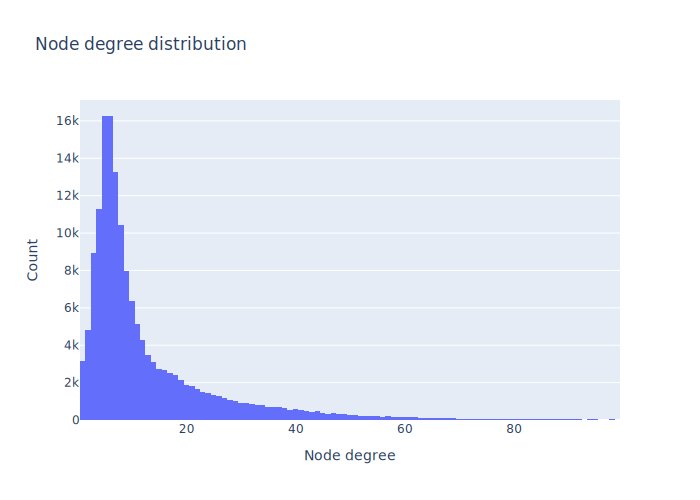

In [6]:
iplot(
  dict(
    data=[go.Histogram(x=[deg for _, deg in ng.degree() if deg < 100])],
    layout=go.Layout(
        title='Node degree distribution',
        xaxis=dict(
            title='Node degree'),
        yaxis=dict(
            title='Count'),
)))

In [15]:
pd.DataFrame([deg for _, deg in ng.degree()]).describe()

,0
count,158900.000000
mean,18.865941
std,370.474405
min,1.000000
25%,5.000000
50%,8.000000
75%,16.000000
max,100432.000000


### 2.7 Relation Distribution 

http://www.wikidata.org/prop/direct/P272


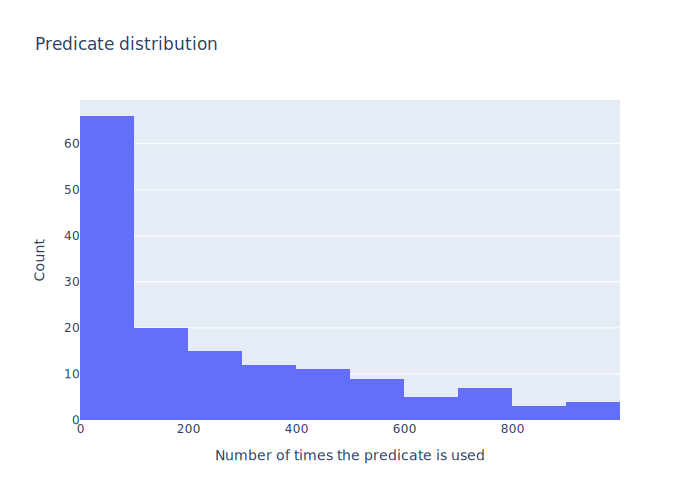

In [7]:
pdeg = defaultdict(int)
for s,p,o in graph.triples((None, None, None)):
    pdeg[p] += 1
print(pdeg[p])  

iplot(dict(
    data=[go.Histogram(x=[cnt for cnt in pdeg.values() if cnt < 1000])],
    layout=go.Layout(
        title='Predicate distribution',
        xaxis=dict(
            title='Number of times the predicate is used'),
        yaxis=dict(
            title='Count'),
)))

In [17]:
pd.DataFrame(list(pdeg.values())).describe()

,0
count,255.000000
mean,8065.792157
std,28238.112826
min,29.000000
25%,94.500000
50%,537.000000
75%,2673.000000
max,288856.000000


### 2.8 Entity types

In [18]:
roots = {
    WD['Q8242']:        'literature',
    WD['Q5']:           'human',
    WD['Q483394']:      'genre',
    WD['Q95074']:       'character',
    WD['Q11424']:       'film',
    WD['Q15416']:       'tv',
    WD['Q618779']:      'award',
    WD['Q27096213']:    'geographic',
    WD['Q43229']:       'organisation',
    WD['Q34770']:       'language',
    WD['Q7725310']:     'series',
    WD['Q47461344']:    'written work',
}

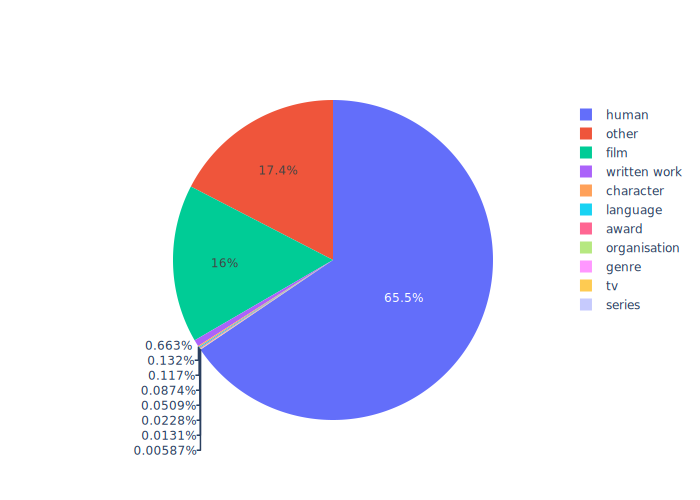

In [19]:
# Histogram w.r.t what's in the actual published graph
ecats = defaultdict(set)
for s, o in graph.subject_objects(WDT.P31):
    c = roots.get(o, 'other')
    ecats[c].add(s)

chist = {c: len(ents) for c, ents in ecats.items()}
labels, values = zip(*chist.items())
iplot(dict(data=[go.Pie(labels=labels, values=values)]))

## 3. SPARQL query examples

In [12]:
# top user-rated movies
[str(s) for s, in graph.query('''
    PREFIX ddis: <http://ddis.ch/atai/> 
    PREFIX wd: <http://www.wikidata.org/entity/> 
    PREFIX wdt: <http://www.wikidata.org/prop/direct/> 
    PREFIX schema: <http://schema.org/> 
    
    SELECT ?lbl WHERE {
        SELECT ?movie ?lbl ?rating WHERE {
            ?movie wdt:P31 wd:Q11424 .
            ?movie ddis:rating ?1 .
            ?movie rdfs:label ?lbl .
        }
        ORDER BY DESC(?rating) 
        LIMIT 20
    }
    ''')]

['Bully',
 'The Chinese Feast',
 'The Super',
 'Nightbreed',
 'Cadillac Man',
 'The Wedding Date',
 'Revolution',
 'Killer Tongue',
 'Hum Tum',
 'Second Name',
 'Captivity',
 'Caravaggio',
 'Perhaps Love',
 'Castle Freak',
 'Showdown in Little Tokyo',
 'Catchfire',
 'Existenz',
 'The Consequences of Love',
 'Volcano',
 'Changing Times']

In [21]:
# bottom user-rated movies
[str(s) for s, in graph.query('''
    PREFIX ddis: <http://ddis.ch/atai/> 
    PREFIX wd: <http://www.wikidata.org/entity/> 
    PREFIX wdt: <http://www.wikidata.org/prop/direct/> 
    PREFIX schema: <http://schema.org/> 
    
    SELECT ?lbl WHERE {
        SELECT ?movie ?lbl ?rating WHERE {
            ?movie wdt:P31 wd:Q11424 .
            ?movie ddis:rating ?rating .
            ?movie rdfs:label ?lbl .
        }
        ORDER BY ASC(?rating) 
        LIMIT 10
    }
    ''')]

['Vampire Assassin',
 'Vampires vs. Zombies',
 'Aag',
 'Joystick Nation – Generation Hip Hop',
 'Going Overboard',
 "Alex l'ariete",
 'House of the Dead',
 'Killers',
 "Ghosts Can't Do It",
 'Snakes on a Train']

In [22]:
# some info about a Apocalypse Now

header = '''
    PREFIX ddis: <http://ddis.ch/atai/>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX schema: <http://schema.org/>
'''

tuple_list = list(graph.query(header + '''
    SELECT * WHERE {
        ?movie rdfs:label "Apocalypse Now"@en .
        ?movie wdt:P57/rdfs:label ?director .
        OPTIONAL { ?movie ddis:rating ?rating } .
        OPTIONAL { ?movie wdt:P577 ?value}
    }
    '''))

first_tuple = tuple_list[0]

print(f"First tuple: {first_tuple}")
print('------------')

for elements in first_tuple:
    print(elements)

First tuple: (rdflib.term.URIRef('http://www.wikidata.org/entity/Q182692'), rdflib.term.Literal('Francis Ford Coppola', lang='en'), rdflib.term.Literal('8.4', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#decimal')), rdflib.term.Literal('1979-05-10', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')))
------------
http://www.wikidata.org/entity/Q182692
Francis Ford Coppola
8.4
1979-05-10


In [23]:
# dealing with optional parameters
tuple_list = list(graph.query(header + '''
    SELECT ?lbl ?rating WHERE {
        ?movie rdfs:label ?lbl .
        ?movie wdt:P57/rdfs:label ?director .
        OPTIONAL { ?movie ddis:rating ?rating } .
        OPTIONAL { ?movie wdt:P577 ?value}
    }
    LIMIT 10
    '''))

# unpacking the tuple in the loop
for (movie_label, rating) in tuple_list:
    if rating:
        print(f"{movie_label} has a rating of {rating} ⭐️")
    else:
        print(f"{movie_label} has no rating 😔")

Jan Dara has no rating 😔
Queens of Langkasuka has no rating 😔
Three has no rating 😔
Moondram Pirai has no rating 😔
Buffalo Bill and the Indians, or Sitting Bull's History Lesson has no rating 😔
Dr. T & the Women has no rating 😔
McCabe & Mrs. Miller has a rating of 7.7 ⭐️
Nashville has no rating 😔
Fool for Love has a rating of 6.1 ⭐️
The Gingerbread Man has a rating of 5.7 ⭐️


In [24]:
# all movies directed by Terry Gilliam
[str(s) for s,  in graph.query('''
    PREFIX ddis: <http://ddis.ch/atai/> 
    PREFIX wd: <http://www.wikidata.org/entity/> 
    PREFIX wdt: <http://www.wikidata.org/prop/direct/> 
    PREFIX schema: <http://schema.org/> 
    
    SELECT ?lbl WHERE {
        ?director rdfs:label "Terry Gilliam"@en .
        ?movie wdt:P57 ?director .
        ?movie rdfs:label ?lbl
    }
    ''')]

['Time Bandits',
 'Tideland',
 "Monty Python's The Meaning of Life",
 'Brazil',
 'The Wholly Family',
 'The Fisher King',
 'The Imaginarium of Doctor Parnassus',
 'The Zero Theorem',
 'The Adventures of Baron Munchausen',
 'Jabberwocky',
 '12 Monkeys',
 'The Man Who Killed Don Quixote',
 'The Brothers Grimm',
 'Fear and Loathing in Las Vegas',
 'Monty Python and the Holy Grail']

In [25]:
# neo-noir movies featuring Ryan Gosling
[str(s) for s, in graph.query('''
    PREFIX ddis: <http://ddis.ch/atai/> 
    PREFIX wd: <http://www.wikidata.org/entity/> 
    PREFIX wdt: <http://www.wikidata.org/prop/direct/> 
    PREFIX schema: <http://schema.org/> 
    
    SELECT ?lbl WHERE {
        ?genre rdfs:label "neo-noir"@en .
        ?actor rdfs:label "Ryan Gosling"@en .
        ?movie wdt:P136 ?genre .
        ?movie wdt:P161 ?actor .
        ?movie rdfs:label ?lbl .
    }
    ''')]

['Only God Forgives', 'Drive', 'Blade Runner 2049']

In [26]:
# movies with largest cast member list
[(str(s), int(nc)) for s, nc in graph.query('''
    PREFIX ddis: <http://ddis.ch/atai/> 
    PREFIX wd: <http://www.wikidata.org/entity/> 
    PREFIX wdt: <http://www.wikidata.org/prop/direct/> 
    PREFIX schema: <http://schema.org/> 
    
    SELECT ?lbl ?nc WHERE {
        SELECT ?movie ?lbl (count(?cast) as ?nc) WHERE {
            ?movie wdt:P31 wd:Q11424 .
            ?movie rdfs:label ?lbl .
            ?movie wdt:P161 ?cast .
        }
        GROUP BY ?movie
        ORDER BY DESC(?nc)
        LIMIT 10
    }
    ''')]

[('Mamma Mia! Here We Go Again', 224),
 ('Ali', 121),
 ('Forrest Gump', 118),
 ('Terror in the Aisles', 110),
 ('Iron Man 3', 108),
 ('The Longest Day', 104),
 ('Avengers: Endgame', 100),
 ('Captain America: Civil War', 98),
 ('Around the World in 80 Days', 93),
 ('Captain America: The First Avenger', 93)]

In [27]:
# cast of Moon
[str(s) for s, in graph.query('''
    PREFIX ddis: <http://ddis.ch/atai/> 
    PREFIX wd: <http://www.wikidata.org/entity/> 
    PREFIX wdt: <http://www.wikidata.org/prop/direct/> 
    PREFIX schema: <http://schema.org/> 
    
    SELECT ?lbl WHERE {
        ?movie rdfs:label "Moon"@en .
        ?movie wdt:P161 ?cast .
        ?cast rdfs:label ?lbl .
    }
    ''')]

['Matt Berry',
 'Kaya Scodelario',
 'Kevin Spacey',
 'Sam Rockwell',
 'Benedict Wong',
 'Dominique McElligott',
 'Robin Chalk']

In [28]:
# winners of Cannes best movie (Palme d'Or)
a = [(str(d), str(s)) for s, d in graph.query(header + '''
    SELECT ?lbl ?pubdate WHERE {
        ?award rdfs:label "Palme d'Or"@en .
        ?movie wdt:P166 ?award .
        ?movie rdfs:label ?lbl .
        ?movie wdt:P577 ?pubdate .
        FILTER (?pubdate > "2011-01-01"^^xsd:date)
    }
    ORDER BY DESC(?pubdate)
    ''')]

# this can be also written as (notice the ";"):
b = [(str(d), str(s)) for s, d in graph.query(header + '''
    SELECT ?lbl ?pubdate WHERE {
      ?award rdfs:label "Palme d'Or"@en.
      ?movie wdt:P166 ?award; rdfs:label ?lbl; wdt:P577 ?pubdate.
      FILTER(?pubdate > "2011-01-01"^^xsd:date)
    }
    ORDER BY DESC (?pubdate)
    ''')]

assert (a == b)
a

[('2021-07-14', 'Titane'),
 ('2019-05-21', 'Parasite'),
 ('2018-05-13', 'Shoplifters'),
 ('2017-05-20', 'The Square'),
 ('2016-10-21', 'I, Daniel Blake'),
 ('2015-10-22', 'Dheepan'),
 ('2014-05-16', 'Winter Sleep'),
 ('2013-05-23', 'Blue Is the Warmest Colour'),
 ('2012-01-01', 'Amour'),
 ('2011-05-16', 'The Tree of Life')]